# 다중 회귀

- 여러 개의 특성을 사용한 선형 회귀
- 회귀식
    - 종속변수 = w1 * x1 + w2 * x2 + ... + y절편
    
<img src = "./img/multiple_regression.png">

# 특성 공학(feature engineering)

- 기존의 특성을 사용해 새로운 특성을 만들어내는 작업 (특성 = 독립변수)
- 특성 공학 기법
    - 차원 축소(Dimension Reduction)
        - 특성 선정(Feature Selection)
            - 특성 랭킹 또는 특성 중요도에 따라 선정
            - 분석가의 사전 배경 지식을 이요하거나, 랜덤 선정 및 측정을 반복하는 방법
        - 특성 추출(Feature Extraction)
            - 특성들의 조합으로 새로운 특성을 생성
    - 스케일링(scaling)
        - 변수의 분포가 편향되어 있을 경우, 변수 간의 관계가 잘 드러나지 않는 경우 범위 변환
    - 변형(Transform)
        - 기존에 존재하는 변수의 성질을 이용해 다른 변수를 생성하는 방법
            - 예) 날짜별 데이터에 주말 여부 추가
    - 비닝(Binning)
        - 연속형 변수를 범주형 변수로 변환
            - 예) 33세, 47세 -> 30대, 40대
    - 더미(Dummy)
        - 범주형 변수를 연속형 범주로 변환
        - 기존 특성이나 특성의 조합을 규칙에 따라 수치화하여 추가

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import matplotlib.pyplot as plt

# 데이터 준비

In [2]:
df = pd.read_csv("./data/FISH.csv")

In [3]:
df = df[df["Species"] == "Perch"][["Weight", "Length2", "Height", "Width"]]

In [4]:
df.head()

,Weight,Length2,Height,Width
72,5.9,8.4,2.1120,1.4080
73,32.0,13.7,3.5280,1.9992
74,40.0,15.0,3.8240,2.4320
75,51.5,16.2,4.5924,2.6316
76,70.0,17.4,4.5880,2.9415


In [5]:
X = df.drop("Weight", axis = 1)
Y = df["Weight"]

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 4)

In [7]:
x_train.shape

(42, 3)

In [8]:
# PolynomialFeatures 사용 예시
pf = PolynomialFeatures()
pf.fit_transform([[2, 3]])

array([[1., 2., 3., 4., 6., 9.]])

In [9]:
# 특성이 어떻게 만들어졌는지 확인
pf.get_feature_names_out()

array(['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2'], dtype=object)

- include_bias : 절편을 추가해주는 파라미터
    - 사이킷런의 선형 회귀 모델은 자동으로 절편을 추가해주기 때문에 굳이 절편을 추가할 필요가 없음

In [10]:
pf = PolynomialFeatures(include_bias = False)
pf.fit_transform([[2, 3]])

array([[2., 3., 4., 6., 9.]])

In [11]:
# 실전 적용
pf = PolynomialFeatures(include_bias = False)
poly_train = pf.fit_transform(x_train)
poly_test = pf.transform(x_test)

In [12]:
poly_train.shape

(42, 9)

# 모델 훈련

In [13]:
# 특성공학 전 데이터로 학습한 모델
lr_org = LinearRegression()
lr_org.fit(x_train, y_train)
lr_org.score(x_test, y_test)

0.9600610520458415

In [14]:
lr_org.score(x_train, y_train)

0.9347016860138706

- 훈련 데이터 평가치가 테스트 데이터 평가치보다 낮음
    - 과소적합

In [15]:
lr_poly = LinearRegression()
lr_poly.fit(poly_train, y_train)
lr_poly.score(poly_test, y_test)

0.9710693711540577

In [16]:
lr_poly.score(poly_train, y_train)

0.9901121643178598

# 모델 최적화

- 특성을 더 추가
    - degree 매개변수 : 고차항의 최대 차수를 지정

In [17]:
pf = PolynomialFeatures(degree = 5, include_bias = False)
poly_train5 = pf.fit_transform(x_train)
poly_test5 = pf.transform(x_test)
poly_train5.shape

(42, 55)

In [18]:
lr_poly5 = LinearRegression()
lr_poly5.fit(poly_train5, y_train)
lr_poly5.score(poly_test5, y_test)

-9.31439509423524

In [19]:
lr_poly5.score(poly_train5, y_train)

0.9999999999999906

- 훈련 데이터에 대해서는 완벽하게 학습했음
- 테스트 데이터에 대해서는 분산보다 오차가 큼
    - 데이터의 평균으로 찍는 것 보다 성능이 떨어짐
    - 과대적합이 일어났음

# 규제(regularization)

- 머신러닝 모델이 훈련 세트를 과도하게 학습하지 못하도록 방지하는 것
    - 선형 회귀 모델의 경우에는 특성의 기울기 크기를 제한
- 선형 회귀 모델에 규제를 가하는 방법에 따라 릿지(Ridge)모델과 라쏘(Lasso)로 나뉨
    - 릿지 모델
        - 계수를 제곱한 값을 제한
        - L2 규제
    - 라쏘 모델
        - 계수의 절댓값을 제한
        - L1 규제

In [20]:
# 일반적으로 선형 회귀 모델에 규제를 적요할 때 계수 값의 크기가 서로 많이 다르면 제어가 힘듦
# 규제 적용 전에 스케일링을 실행
ss = StandardScaler()
scaled_train = ss.fit_transform(poly_train5)
scaled_test = ss.transform(poly_test5)

# 릿지 회귀

In [21]:
rid = Ridge()

In [22]:
rid.fit(scaled_train, y_train)
rid.score(scaled_test, y_test)

0.9621128839439498

In [23]:
rid.score(scaled_train, y_train)

0.9897127571191621

## 초매개변수(hyperparameter)

- 머신러닝 모델이 학습할 수 없고 사람이 설정해야하는 파라미터
- 사이킷런 모델에서 하이퍼파라미터는 클래스의 매개변수로 표현됨

### 릿지 모델 하이퍼파라미터 튜닝

- alpha : 규제의 강도
    - alpha 값이 크면
        - 규제의 강도가 세짐
        - 계수의 값을 줄이고 과소적합을 유도
    - alpha 값이 작으면
        - 규제의 강도가 약해짐
        - 계수의 값을 덜 줄이고 과대적합 가능성이 커짐

In [24]:
train_hist = []
test_hist = []

alpha_li = [0.001, 0.1, 0.1, 1, 10, 100]

for alpha in alpha_li:
    # 모델 생성
    rid = Ridge(alpha = alpha)
    # 훈련
    rid.fit(scaled_train, y_train)
    # 모델 성능을 저장
    train_hist.append(rid.score(scaled_train, y_train))
    test_hist.append(rid.score(scaled_test, y_test))

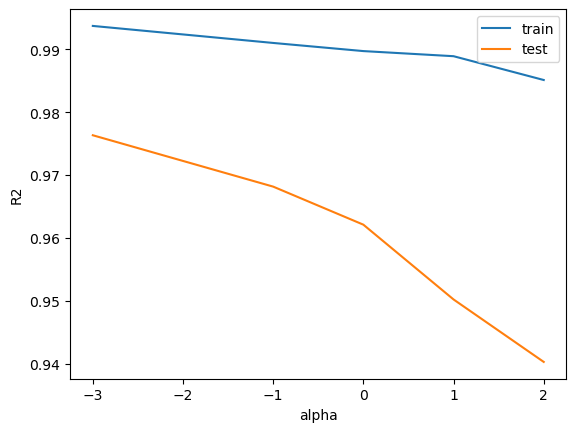

In [28]:
plt.figure()
# alpha 값을 그대로 x에 적용하면 간격이 서로 다르기 때문에 로그 함수로 바꾸어서 시각화
plt.plot(np.log10(alpha_li), train_hist)
plt.plot(np.log10(alpha_li), test_hist)
plt.xlabel("alpha")
plt.ylabel("R2")
plt.legend(labels = ["train", "test"])
plt.show()

- alpha가 커질수록 훈련 데이터 점수가 낮아짐
    - 과소적합으로 유도되고 있음
- 테스트 데이터에 가장 점수가 높은 alpha값은 0.001임

In [29]:
rid = Ridge(alpha = 0.001)
rid.fit(scaled_train, y_train)
print(rid.score(scaled_train, y_train))
print(rid.score(scaled_test, y_test))

0.993713761376372
0.9763301355470846


# 라쏘 회귀

In [30]:
las = Lasso()
las.fit(scaled_train, y_train)
print(las.score(scaled_train, y_train))
print(las.score(scaled_test, y_test))

0.9899528568250525
0.9639213215378303


C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.487e+02, tolerance: 5.416e+02
  model = cd_fast.enet_coordinate_descent(


## 라쏘 모델 하이퍼파라미터 튜닝

In [31]:
train_hist = []
test_hist = []

alpha_li = [0.001, 0.1, 0.1, 1, 10, 100]

for alpha in alpha_li:
    # 모델 생성
    las = Lasso(alpha = alpha)
    # 훈련
    las.fit(scaled_train, y_train)
    # 모델 성능을 저장
    train_hist.append(las.score(scaled_train, y_train))
    test_hist.append(las.score(scaled_test, y_test))

C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.203e+04, tolerance: 5.416e+02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.506e+03, tolerance: 5.416e+02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.506e+03, toleranc

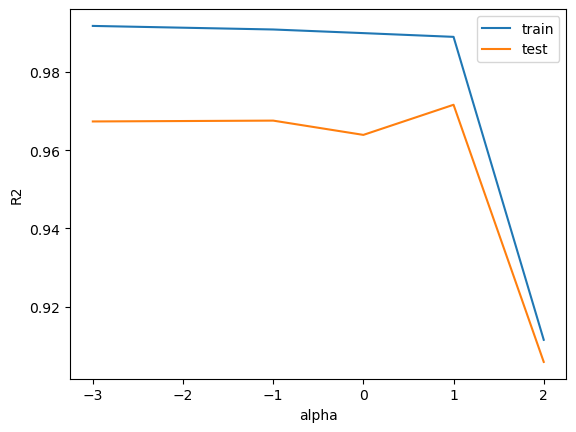

In [32]:
plt.figure()
# alpha 값을 그대로 x에 적용하면 간격이 서로 다르기 때문에 로그 함수로 바꾸어서 시각화
plt.plot(np.log10(alpha_li), train_hist)
plt.plot(np.log10(alpha_li), test_hist)
plt.xlabel("alpha")
plt.ylabel("R2")
plt.legend(labels = ["train", "test"])
plt.show()